In [1]:
import os
import logging

import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

2024-04-14 16:58:20.611426: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Import the saved model. Setup the paths and labels.

In [20]:
label_names = ['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes']
data_dir = pathlib.Path('data')
imported = tf.saved_model.load('saved')

In [21]:
def get_waveform(wavfile):
    x = tf.io.read_file(str(wavfile))
    x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000)
    return tf.squeeze(x, axis=-1)


def get_spectrogram(waveform):
    # Convert the waveform to a spectrogram via a STFT
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)

    # Obtain the magnitude of the STFT
    spectrogram = tf.abs(spectrogram)

    # Add a 'channels' dimension, so that the spectrogram can be used as an
    # image-like input data w/ convolution layers, which expect shape
    # (batch_size, height, width, channels)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram


def get_saved_model(wavfile):
    waveform = get_waveform(wavfile)
    m = imported(waveform[tf.newaxis, :])
    return m, waveform

## Test a wavfile

In [22]:
m, waveform = get_saved_model(data_dir/'test/h_yes.wav')
m

{'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'yes'], dtype=object)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([7])>,
 'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[-1.4015254 , -0.47578493, -0.17762837, -1.3689332 ,  0.02886982,
         -4.9320793 , -4.903058  ,  4.8657074 ]], dtype=float32)>}

In [23]:
label = label_names[m['predictions'].numpy().argmax()]
print('Prediction:', label)

Prediction: yes


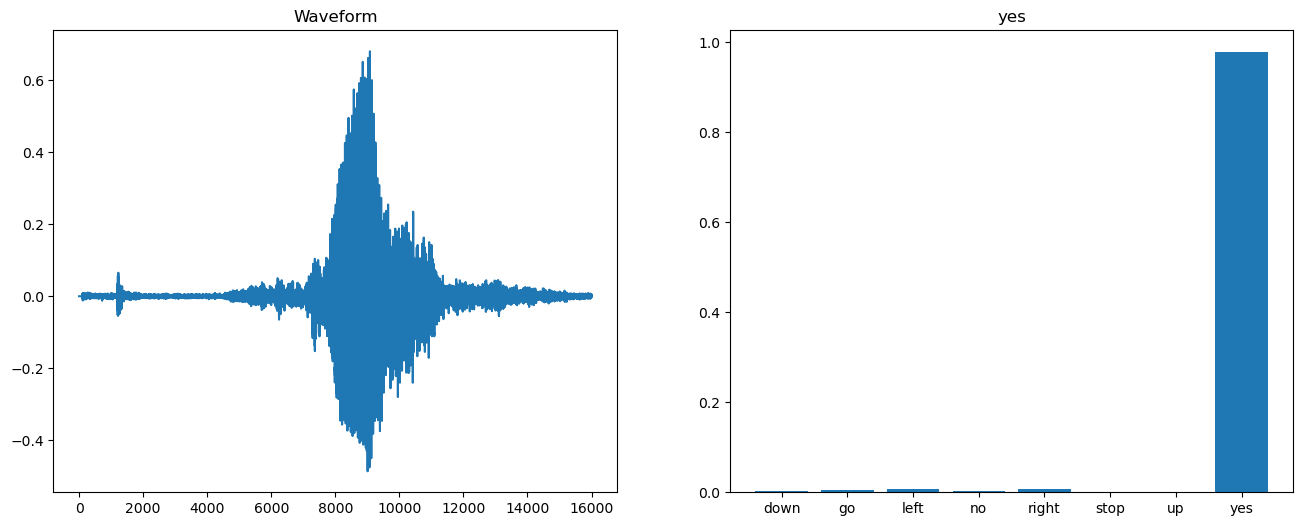

In [24]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
timescale = np.arange(waveform.shape[0])
plt.plot(timescale, waveform.numpy())
plt.title('Waveform')

plt.subplot(1,2,2)
plt.bar(label_names, tf.nn.softmax(m['predictions'][0]))
plt.title(label)
plt.show()

display.display(display.Audio(waveform, rate=16000))

## Load the model saved in HDF5 format

In [25]:
h5_model = tf.keras.models.load_model('simple_audio.h5')
h5_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0

## Test the HDF5 model

In [8]:
input_data = get_spectrogram(waveform)
input_data = input_data[tf.newaxis,...]
result = h5_model(input_data, training=False)
label = label_names[m['predictions'].numpy().argmax()]
print('Prediction:', label)
result

Prediction: yes


<tf.Tensor: shape=(1, 8), dtype=float32, numpy=
array([[-1.4015254 , -0.47578493, -0.17762837, -1.3689332 ,  0.02886982,
        -4.9320793 , -4.903058  ,  4.8657074 ]], dtype=float32)>

## Explore the model layers

In [45]:
h5_model.layers

In [9]:
spec = get_spectrogram(waveform)
input_data = spec[tf.newaxis,...]
input_data.shape, input_data[0,0,:10,:]

(TensorShape([1, 124, 129, 1]),
 <tf.Tensor: shape=(10, 1), dtype=float32, numpy=
 array([[0.00021577],
        [0.00242205],
        [0.00827248],
        [0.01238501],
        [0.01051275],
        [0.01144113],
        [0.01872324],
        [0.02427843],
        [0.04116756],
        [0.09470174]], dtype=float32)>)

In [10]:
layers.Input(shape=input_data.shape)

<KerasTensor: shape=(None, 1, 124, 129, 1) dtype=float32 (created by layer 'input_1')>

In [11]:
# Downsample the input
l1 = layers.Resizing(32, 32)(input_data)
l1.shape

TensorShape([1, 32, 32, 1])

In [47]:
# Normalize
norm_layer = h5_model.layers[1]
l2 = norm_layer(l1.numpy())  #tf.convert_to_tensor(l1 / np.linalg.norm(l1.numpy()), dtype=tf.float32)
l2.shape

TensorShape([1, 32, 32, 1])

In [13]:
l3 = layers.Conv2D(32, 3, activation='relu')(l2.numpy())
l3.shape

TensorShape([1, 30, 30, 32])

In [14]:
l4 = layers.Conv2D(64, 3, activation='relu')(l3.numpy())
l4.shape

TensorShape([1, 28, 28, 64])

In [15]:
l5 = layers.Dropout(0.25)(l4.numpy())
l5.shape

TensorShape([1, 28, 28, 64])

In [16]:
l6 = layers.Flatten()(l5.numpy())
l6.shape

TensorShape([1, 50176])

In [17]:
l7 = layers.Dense(128, activation='relu')(l6.numpy())
l7.shape

TensorShape([1, 128])

In [18]:
l8 = layers.Dropout(0.5)(l7.numpy())
l8.shape

TensorShape([1, 128])

In [19]:
l9 = layers.Dense(len(label_names))(l8.numpy())
l9.shape

TensorShape([1, 8])